# 修复版本的LLT策略回测

这个版本修复了原始notebook中的以下问题：
1. 交易数量为0的问题
2. 持仓价值计算错误
3. 交易逻辑问题

主要修复：
- 使用 `order_target_percent()` 而不是 `order_target_size()`
- 修复了PortfolioLogger的递归问题
- 添加了详细的交易日志

In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import datetime
from llt_strategy import LLTStrategy, llt_slope_signal, llt_slope_quantiles, calculate_llt

In [2]:
class TradeLogger(bt.Observer):
    """简化的交易日志记录器"""
    lines = ('value',)
    
    def __init__(self):
        self.trade_count = 0
        
    def next(self):
        # 记录组合价值
        self.l.value[0] = self._owner.broker.getvalue()
        
        # 获取当前持仓信息
        cash = self._owner.broker.getcash()
        total_value = self._owner.broker.getvalue()
        
        # 计算持仓价值和数量
        position_value = 0
        position_size = 0
        
        for data in self._owner.datas:
            position = self._owner.getposition(data)
            position_size = position.size
            if position.size != 0:
                position_value = position.size * data.close[0]
        
        # 每天打印组合状态（仅在有交易信号时）
        date = self._owner.data.datetime.date(0)
        if hasattr(self._owner, '_last_position_size'):
            if position_size != self._owner._last_position_size:
                print(f"{date} - 持仓:{position_size:.0f}股, 持仓价值:{position_value:.2f}, 现金:{cash:.2f}, 总价值:{total_value:.2f}")
        self._owner._last_position_size = position_size

In [10]:
def run_backtest(data, d=39, thresh=(-0.02, 0.02), slope_window=5, initial_cash=1_000_0000):
    cerebro = bt.Cerebro()

    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(commission=0.0001)

    cerebro.addstrategy(LLTStrategy, d=d, thresh = thresh, slope_window=slope_window)
    
    bt_data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(bt_data)
    
    # 添加日志
    cerebro.addwriter(bt.WriterFile, rounding=2, csv=True)
    
    # 添加绩效分析器
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    # 运行回测
    print(f"初始资金: {cerebro.broker.getvalue():.2f}")
    results = cerebro.run()
    final_value = cerebro.broker.getvalue()
    print(f"最终资金: {final_value:.2f}")
    
    # 输出绩效指标
    strat = results[0]
    returns = strat.analyzers.returns.get_analysis()
    sharpe = strat.analyzers.sharpe.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()
    
    print(f"夏普比率: {sharpe.get('sharperatio', 0):.2f}")
    print(f"最大回撤: {drawdown.get('max', {}).get('drawdown', 0):.2f}%")
    print(f"年化收益率: {returns.get('rnorm', 0):.2%}")

def optimize(data, d, thresh):
    cerebro = bt.Cerebro()

    cerebro.broker.setcash(1_000_0000)
    # 万分之一的佣金。现在多数券商给到了万分之0.854
    cerebro.broker.setcommission(commission=0.0001)
    
    bt_data = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(bt_data)
    
    # 添加绩效分析
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    
    cerebro.optstrategy(LLTStrategy, d = d, thresh = thresh)
    strats = cerebro.run(maxcpus = 6, optreturn = True)

    params_and_returns = []
    for s in strats:
        returns = s[0].analyzers.returns.get_analysis()
        d, thresh = s[0].params.d, s[0].params.thresh[0]
        
        rnorm, pnl = f"{returns['rnorm']:.2%}", f"{returns['rtot']:.2%}"
        params_and_returns.append((d, thresh, rnorm, pnl))

    return pd.DataFrame(params_and_returns, columns=["d", "thresh", "rnorm", "pnl"])

In [11]:
data = pd.read_csv('sh.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

# 运行回测
result = optimize(data, (5, 10, 20, 30, 60), ((-0.01, 0.01), (-0.02, 0.02), (-0.04, 0.04), (-0.08, 0.08), (-0.12, 0.12), (-0.24, 0.24)))
result

策略初始化完成，信号数量: 2914
信号前20个值: date
2013-01-04    0
2013-01-07    0
2013-01-08    0
2013-01-09    0
2013-01-10    1
2013-01-11   -1
2013-01-14   -1
2013-01-15    1
2013-01-16    1
2013-01-17    1
2013-01-18    1
2013-01-21    1
2013-01-22    1
2013-01-23    1
2013-01-24    1
2013-01-25   -1
2013-01-28   -1
2013-01-29    1
2013-01-30    1
2013-01-31    1
dtype: int64
日期: 2013-01-10, 信号: 1, 当前持仓: 0
做多信号: 2013-01-10
日期: 2013-01-11, 信号: -1, 当前持仓: 4159
做空信号: 2013-01-11
日期: 2013-01-14, 信号: -1, 当前持仓: -4160
做空信号: 2013-01-14
日期: 2013-01-15, 信号: 1, 当前持仓: -3896
做多信号: 2013-01-15
日期: 2013-01-16, 信号: 1, 当前持仓: 3850
做多信号: 2013-01-16
日期: 2013-01-17, 信号: 1, 当前持仓: 3861
做多信号: 2013-01-17
日期: 2013-01-18, 信号: 1, 当前持仓: 3864
做多信号: 2013-01-18
日期: 2013-01-21, 信号: 1, 当前持仓: 3862
做多信号: 2013-01-21
日期: 2013-01-22, 信号: 1, 当前持仓: 3861
日期: 2013-01-23, 信号: 1, 当前持仓: 3861
日期: 2013-01-24, 信号: 1, 当前持仓: 3861
做多信号: 2013-01-24
日期: 2013-01-25, 信号: -1, 当前持仓: 3862
做空信号: 2013-01-25
日期: 2013-01-28, 信号: -1, 当前持仓: -3863
做空信号: 2013-01-28
日

d  thresh   rnorm      pnl
0    5   -0.01  -3.76%  -44.27%
1    5   -0.02  -3.87%  -45.70%
2    5   -0.04  -3.79%  -44.68%
3    5   -0.08  -3.86%  -45.46%
4    5   -0.12  -3.89%  -45.93%
5    5   -0.24  -3.72%  -43.86%
6   10   -0.01  -7.11%  -85.23%
7   10   -0.02  -7.11%  -85.23%
8   10   -0.04  -7.08%  -84.87%
9   10   -0.08  -7.11%  -85.34%
10  10   -0.12  -7.05%  -84.50%
11  10   -0.24  -6.56%  -78.51%
12  20   -0.01  -4.38%  -51.82%
13  20   -0.02  -4.11%  -48.50%
14  20   -0.04  -4.10%  -48.37%
15  20   -0.08  -3.72%  -43.82%
16  20   -0.12  -3.76%  -44.29%
17  20   -0.24  -2.96%  -34.75%
18  30   -0.01  -3.20%  -37.66%
19  30   -0.02  -3.18%  -37.32%
20  30   -0.04  -3.42%  -40.28%
21  30   -0.08  -3.68%  -43.36%
22  30   -0.12  -3.58%  -42.12%
23  30   -0.24  -3.84%  -45.23%
24  60   -0.01   2.73%   31.11%
25  60   -0.02   2.88%   32.84%
26  60   -0.04   2.64%   30.14%
27  60   -0.08   2.28%   26.07%
28  60   -0.12   2.16%   24.68%
29  60   -0.24   2.11%   24.09%

In [8]:
result.loc[result.index % 3 ==0]

d  thresh   rnorm      pnl
0    5   -0.01  -3.76%  -44.27%
3    5   -0.08  -3.86%  -45.46%
6   10   -0.01  -7.11%  -85.23%
9   10   -0.08  -7.11%  -85.34%
12  20   -0.01  -4.38%  -51.82%
15  20   -0.08  -3.72%  -43.82%
18  30   -0.01  -3.20%  -37.66%
21  30   -0.08  -3.68%  -43.36%
24  60   -0.01   2.73%   31.11%
27  60   -0.08   2.28%   26.07%

np.float64(0.47323266986959506)

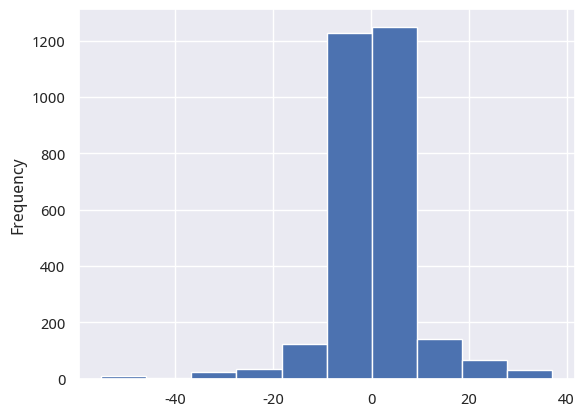

In [4]:
def llt_slope(df, d: int=30, slope_window=5):
    df = df.copy()
    alpha = 2 / (d + 1)
    df["llt"] = calculate_llt(df["close"], alpha)
    df['slope'] = (df["llt"].rolling(slope_window)
                    .apply(lambda x: np.polyfit(np.arange(slope_window), x, 1)[0]))
    
    return df['slope']

slopes = llt_slope(data, d = 60)
slopes.plot(kind='hist')
(slopes < -0.02).sum()/len(slopes)

In [13]:
data = pd.read_csv('sh.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

run_backtest(data, d=59, thresh=(-0.01, 0.01))

初始资金: 10000000.00
策略初始化完成，信号数量: 2914
信号前20个值: date
2013-01-04    0
2013-01-07    0
2013-01-08    0
2013-01-09    0
2013-01-10    1
2013-01-11    1
2013-01-14    1
2013-01-15    1
2013-01-16    1
2013-01-17    1
2013-01-18    1
2013-01-21    1
2013-01-22    1
2013-01-23    1
2013-01-24    1
2013-01-25    1
2013-01-28    1
2013-01-29    1
2013-01-30    1
2013-01-31    1
dtype: int64
Id,,len,datetime,open,high,low,close,volume,openinterest,LLTStrategy,len,datetime,Broker,len,cash,value,BuySell,len,buy,sell,Trades - Net Profit/Loss,len,pnlplus,pnlminus
1,,1,2013-01-04 00:00:00,2289.51,2296.113,2256.56,2276.992,,,LLTStrategy,1,734872.0,Broker,1,10000000.0,10000000.0,BuySell,1,,,Trades - Net Profit/Loss,1,,
2,,2,2013-01-07 00:00:00,2271.663,2293.317,2266.862,2285.364,,,LLTStrategy,2,734875.0,Broker,2,10000000.0,10000000.0,BuySell,2,,,Trades - Net Profit/Loss,2,,
3,,3,2013-01-08 00:00:00,2284.654,2289.139,2262.979,2276.07,,,LLTStrategy,3,734876.0,Broker,3,10000000.0,10000000.0,BuySell,3,,,Tra